# Random forests for house price prediction

Your Name

The purpose of this assignment is to give you experience with ensemble methods while answering a couple of questions:
- How do random forests perform, compared to single trees?
- What are the hyperparameters of random forests?  Does tuning take a long time?
- What does the concept of "feature importance" in random forests mean? 

We'll examine these questions using the CA Housing dataset.  You can get information about the dataset here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset.

You will probably want to look at that web page to understand the variables in the dataset.

There are three problems to solve.

__Instructions__:
- Read this notebook to get a feeling for its structure.  Don't modify the top-level structure.
- Don't modify the cell that loads the data.
- Write code to answer the 3 problems.  Look for # YOUR CODE HERE comments.  You also need to write a summary at the end of each problem.
- Please make sure to read the grading rubric.

In [1]:
# add more imports as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [2]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

## Loading the data

From 8 numeric predictors we will try to predict the house value.

In [3]:
# df is a data frame of the predictors; target is a Series with the target
bunch = fetch_california_housing(as_frame=True)
df = bunch.data
target = bunch.target

## Data exploration

You can add more data exploration if you like, but it's not needed.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


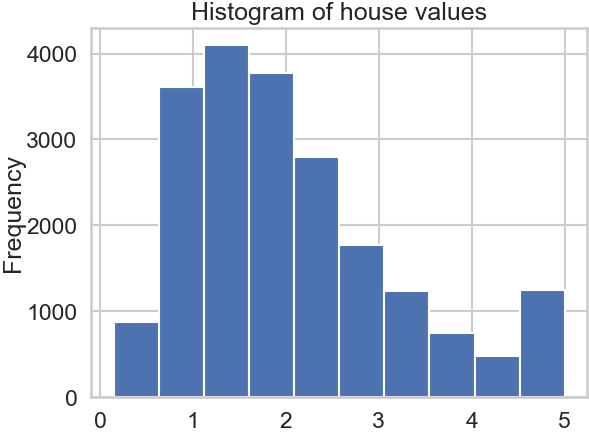

In [6]:
target.plot.hist()
plt.title('Histogram of house values');

#### Check for outlier values of predictor variables

In [7]:
# normalize to make it easier to see outliers
dfs = df.apply(zscore)

# https://stackoverflow.com/questions/41328633 explains formatting
with pd.option_context('float_format', '{:.2f}'.format): 
    print(dfs.describe(percentiles=[0.5, 0.95, 0.99])) 

        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
count 20640.00  20640.00  20640.00   20640.00    20640.00  20640.00  20640.00   
mean      0.00      0.00      0.00      -0.00       -0.00      0.00     -0.00   
std       1.00      1.00      1.00       1.00        1.00      1.00      1.00   
min      -1.77     -2.20     -1.85      -1.61       -1.26     -0.23     -1.45   
50%      -0.18      0.03     -0.08      -0.10       -0.23     -0.02     -0.64   
95%       1.81      1.86      0.89       0.37        1.64      0.12      1.56   
99%       3.54      1.86      1.99       2.18        3.87      0.22      2.34   
max       5.86      1.86     55.16      69.57       30.25    119.42      2.96   

       Longitude  
count   20640.00  
mean       -0.00  
std         1.00  
min        -2.39  
50%         0.54  
95%         1.24  
99%         1.64  
max         2.63  


The result of describe on the z-score normalized values show some extreme outliers in variables AveRooms, AveBedrms, Population, and AveOccup.

## Data preprocessing

In this section we first remove the outliers found earlier, then perform a test/train split and scale the data.

Also, a smaller version of the dataset is created to speed up hyperparameter tuning.

#### Remove outliers in columns that have significant outliers.

note: re-running this will result in data reduction due to calculating `high_vals` at each evaluation

In [8]:
high_vals = df.quantile(0.99)
for col in ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']:
    mask = df[col] <= high_vals[col]
    df = df[mask]
    target = target[mask]

#### How many rows after outlier removal? 

In [9]:
print(f'Number of rows in data frame: {df.shape[0]}')

Number of rows in data frame: 20000


#### Transform the data to NumPy arrays, perform a train/test split, and then scale the data.

The test data is not used in fitting the scaler -- that would "leak" information about the test data.

In [10]:
X = df.values
y = target.values

# 20% should be enough for the test set, as the data set has 20K rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Make a smaller version of the training data to allow for faster hyperparameter tuning.

In [11]:
# Use 50% of the data in the sample
np.random.seed(0)
m = X_train.shape[0]
rows = np.random.choice(m, size=int(m*0.5), replace=False)
X_train_s = X_train[rows]
y_train_s = y_train[rows]

In [12]:
X_train_s.shape

(8000, 8)

## Problem 1. Regression with a single regression tree

In this problem you will tune a regression tree using GridSearchCV, then look at the importance of the features.

### Hyperparameter tuning using GridSearchCV

In [20]:
# Use GridSearchCV to tune a DecisionTreeRegressor.  
# You will need to create a dictionary, which is often given variable name 'param_grid'.
# Only tune the DecisionTreeRegressor hyperparameters 'max_leaf_nodes' and 'max_depth'.  
# Be sure to include large enough possible values

# Hint: create a GridSearchCV object and then use the .fit() method.
# Hint: don't forget to specify the scoring parameter when you use GridSearchCV.

# YOUR CODE HERE
gscv = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid={
        "max_leaf_nodes" : [2**i for i in range(1, 10)],
        "max_depth" : [2**i for i in range(1, 10)]
    },
    scoring="neg_root_mean_squared_error",
    cv=10
)

gscv.fit(X_train_s, y_train_s)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256, 512],
                         'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128, 256,
                                            512]},
             scoring='neg_root_mean_squared_error')

### Report on the best parameters and the score associated with them.

In [22]:
# Print the best hyperparameter values and the best CV RMSE value.
# Use two print statements.
# Hint: you can get the values you want from your trained GridSearchCV object.


print(f"gscv.best_params_: {gscv.best_params_}")
print(f"gscv.best_score_: {gscv.best_score_}")
# YOUR CODE HERE

gscv.best_params_: {'max_depth': 32, 'max_leaf_nodes': 64}
gscv.best_score_: -0.6691858839258003


### Feature importance

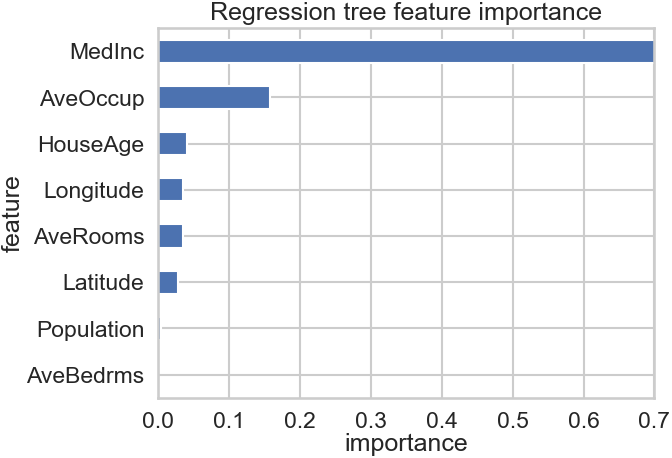

In [27]:
# Create a horizontal bar plot showing the feature importance for each predictor variable.
# Give the plot an appropriate title and x/y axis labels.

# Hint: you can get the feature importances from your GridSearchCV object by
# first accessing the best estimator that the GridSearchCV found.

# YOUR CODE HERE
importance = pd.Series(gscv.best_estimator_.feature_importances_)
importance.index = df.columns
importance.sort_values().plot.barh(title='Regression tree feature importance')
plt.xlim(0, 0.7)
plt.xlabel('importance')
plt.ylabel('feature');

### Summary

Replace this text with your own discussion about what you learned on this problem.

## Problem 2. Regression with a random forest

For this problem you tune a random forest and see how well it performs.  Does it outperform a single tree?

### Hyperparameter tuning

Note that a `max_features` value of 1 means "bagged trees".

In [28]:
# Perform GridSearchCV again, but this time with a RandomForestRegressor.
# Your param_grid should contain values for only max_depth and max_features.
# For max_depth, I recommend you look at some small integer values, plus value None.
# For max_features, I recommend you look at values 1.0 and 'sqrt'.
# Read the RandomForestRegressor to understand what these hyperparameter values mean.

# Hint: don't consider too many values in your param grid, because this can take a while to run.

# YOUR CODE HERE
gscv_rf = GridSearchCV(
    RandomForestRegressor(),
    param_grid={
        "max_features" : [2**i for i in range(1, 10)],
        "max_depth" : [2**i for i in range(1, 10)]
    },
    scoring="neg_root_mean_squared_error",
    cv=10
)

gscv_rf.fit(X_train_s, y_train_s)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256, 512],
                         'max_features': [2, 4, 8, 16, 32, 64, 128, 256, 512]},
             scoring='neg_root_mean_squared_error')

### Report on the best parameters and the score associated with them.

In [29]:
# Produce output similar to what you did for a single regression tree.

# YOUR CODE HERE

print(f"gscv_rf.best_params_: {gscv_rf.best_params_}")
print(f"gscv_rf.best_score_: {gscv_rf.best_score_}")

gscv_rf.best_params_: {'max_depth': 32, 'max_features': 2}
gscv_rf.best_score_: -0.5143490175309473


### Feature importance

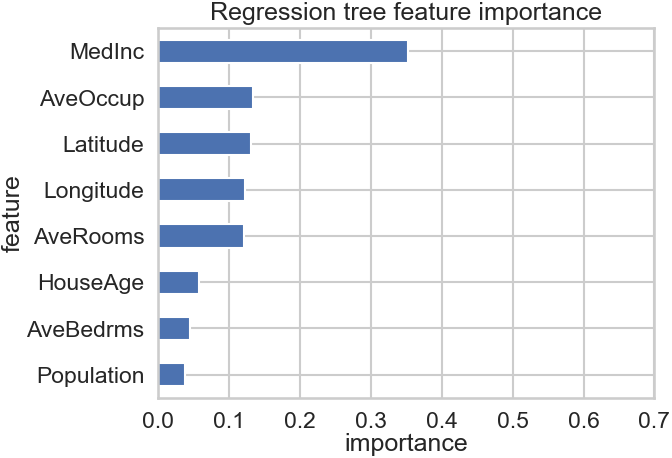

In [30]:
# RandomForestRegressor also supports the concept of feature importance.
# Print a horizontal bar plot like you did for your single regression tree.

# YOUR CODE HERE

# YOUR CODE HERE
importance = pd.Series(gscv_rf.best_estimator_.feature_importances_)
importance.index = df.columns
importance.sort_values().plot.barh(title='Regression tree feature importance')
plt.xlim(0, 0.7)
plt.xlabel('importance')
plt.ylabel('feature');

### Summary

Replace this text with your own discussion about what you learned on this problem.  Be sure to compare your results for random forests with your results for a single regression tree.

## Problem 3. Tuning the number of base regressors

Now we find the best number of best regressors, keeping the hyperparameter values in the last part unchanged.

In [31]:
# Create a param_grid dictionary based on the best hyperparameter you found in the last problem.
# The dictionary should have a list containing only one value for those hyperparameters,
# but should additionally have a 'n_estimators' key that has as its value a list with multiple elements.

# Hint: to create a param_grid from a dictionary of best hyperparameter values, you can
# use a dictionary comprehension, like this:
# param_grid = {k: [v] for k, v in best_hyper_vals.items()}

gscv_rf_numregressors = GridSearchCV(
    RandomForestRegressor(),
    param_grid={
        "max_features" : [2],
        "max_depth" : [32],
        "n_estimators" : [2**i for i in range(1, 11)]
        
    },
    scoring="neg_root_mean_squared_error",
    cv=10
)


In [32]:
# leave this cell alone
print(param_grid)

NameError: name 'param_grid' is not defined

In [33]:
# Perform a grid search again.  Now the only parameter being tuned is n_estimators.

gscv_rf_numregressors.fit(X_train_s, y_train_s)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [32], 'max_features': [2],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256, 512,
                                          1024]},
             scoring='neg_root_mean_squared_error')

In [34]:
# As before, print the best hyperparameter values and the best CV RMSE.


print(f"gscv_rf_numregressors.best_params_: {gscv_rf_numregressors.best_params_}")
print(f"gscv_rf_numregressors.best_score_: {gscv_rf_numregressors.best_score_}")

gscv_rf_numregressors.best_params_: {'max_depth': 32, 'max_features': 2, 'n_estimators': 512}
gscv_rf_numregressors.best_score_: -0.5104095982436871


#### Examine how score varies by the number of estimators

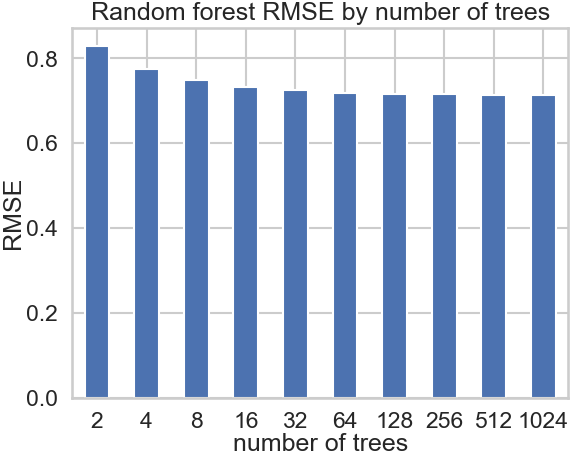

In [35]:
# Create a bar plot showing RMSE (y axis) by number of tree (x axis)

# Hint: I found it useful to use pd.DataFrame() on the cross validation results.
rf_results = pd.DataFrame(gscv_rf_numregressors.cv_results_)
rf_scores = pd.Series(np.sqrt(-rf_results['mean_test_score']))
rf_scores.index = rf_results['param_n_estimators']
rf_scores.plot.bar(rot=0, title='Random forest RMSE by number of trees')
plt.xlabel('number of trees')
plt.ylabel('RMSE');

### Summary

Replace this text with your own comments on what you learned in this problem.